In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as Functional
import torch.optim as optim
%matplotlib inline

In [15]:
# Use to dump debug info
debugOffline = False 
# IsCuda Available
IsCuda = torch.cuda.is_available()

In [3]:
# Collect data to plot graphs at end
# trainLossLog = []
print IsCuda

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                       download = True, transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                       download = True, transform = transform)

testloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


  car plane  ship truck


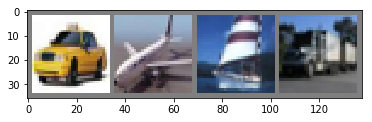

In [6]:
def imShow(img):
    # Denormalize
    img = img / 2 + 0.5
    npImg = img.numpy()
    plt.imshow(np.transpose(npImg, (1, 2, 0)))
    
# Get some random training images
dataIter = iter(trainloader)
images, labels = dataIter.next()

# Show Images
imShow(torchvision.utils.make_grid(images))

# Print Labels
print ' '.join('%5s' % classes[labels[j]] for j in range(4))

In [7]:
# Define CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(Functional.relu(self.conv1(x)))
        x = self.pool(Functional.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = Functional.relu(self.fc1(x))
        x = Functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d (3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=10)
)


In [8]:
# Define Loss Function and Optimizer
# Will be using Stochastic Gradient Descent 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [9]:
# Train the network
def Train(epochs = 2):
    trainLoss = [0] * epochs
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # Get the inputs
            inputs, labels = data

            # Wrap in Variables
            inputs, labels = Variable(inputs), Variable(labels)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + Backward + Optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Stats
            running_loss += loss.data[0]
            if i % 2000 == 1999: 
                # Print every 2000th mini-batches
                print '[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000)
                trainLoss[epoch-1] = running_loss / 2000 
                running_loss = 0.0
    # Copy log into global log
    # trainLossLog = trainLoss
    print 'Training Done!'

In [10]:
# Test the network
if (debugOffline):
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # Print images
    imShow(torchvision.utils.make_grid(images))
    print 'Ground truth: ', ' '.join('%5s'%classes[labels[j]] for j in range(4))
    
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    print 'Predicted: ', ' '.join('%5s'% classes[labels[j]] for j in range(4))

In [11]:
# Accuracy over whole dataset
def TestAll():
    correct = 0
    total = 0
    # Class wise accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    for data in testloader:
        images, labels = data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i]
            class_total[label] += 1

    print 'Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total)
    for i in range(10):
        print 'Accuracy of %5s: %2d%%' % (classes[i], 100 * class_correct[i] / class_total[i])

In [12]:
def TrainAndTest(epochs):
    print '==Training for epochs: ', epochs
    Train(epochs)
    print '==Testing for epochs: ', epochs
    TestAll()

In [13]:
TrainAndTest(2)

==Training for epochs:  2
[1,  2000] loss: 2.268
[1,  4000] loss: 1.912
[1,  6000] loss: 1.695
[1,  8000] loss: 1.581
[1, 10000] loss: 1.509
[1, 12000] loss: 1.466
[2,  2000] loss: 1.393
[2,  4000] loss: 1.358
[2,  6000] loss: 1.325
[2,  8000] loss: 1.304
[2, 10000] loss: 1.272
[2, 12000] loss: 1.266
Training Done!
==Testing for epochs:  2
Accuracy of the network on the 10000 test images: 56 %
Accuracy of plane: 73%
Accuracy of   car: 84%
Accuracy of  bird: 46%
Accuracy of   cat: 30%
Accuracy of  deer: 55%
Accuracy of   dog: 55%
Accuracy of  frog: 65%
Accuracy of horse: 56%
Accuracy of  ship: 58%
Accuracy of truck: 40%


In [14]:
# Epoch 4
TrainAndTest(2)

==Training for epochs:  2
[1,  2000] loss: 1.191
[1,  4000] loss: 1.204
[1,  6000] loss: 1.181
[1,  8000] loss: 1.192
[1, 10000] loss: 1.154
[1, 12000] loss: 1.176
[2,  2000] loss: 1.092
[2,  4000] loss: 1.085
[2,  6000] loss: 1.074
[2,  8000] loss: 1.098
[2, 10000] loss: 1.093
[2, 12000] loss: 1.072
Training Done!
==Testing for epochs:  2
Accuracy of the network on the 10000 test images: 66 %
Accuracy of plane: 69%
Accuracy of   car: 78%
Accuracy of  bird: 62%
Accuracy of   cat: 40%
Accuracy of  deer: 53%
Accuracy of   dog: 63%
Accuracy of  frog: 74%
Accuracy of horse: 69%
Accuracy of  ship: 71%
Accuracy of truck: 80%
